# **DETECCION DE POSIBLE COVID DE COVID-19 A BASE DE LA VOZ**
Objetivo: Estudiar diferentes aspectos que contiene la tos humana a partir de audios con el objetivo de predecir un posible caso de Covid-19, mediante un problema de clasificación binaria.

* Dataset Usado: SpartaCov - Detect Covid from cough
* Modelos implementados: GaussianNB, DecisionTree, RandomForest, Deep Learning

In [ ]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Cositas UIS/IA 1/Coughs')

Mounted at /content/drive


In [ ]:
#@title CARGA DE LIBRERIAS { display-mode: "form" }
import os
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
from sklearn.model_selection import KFold

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *

2.8.0


## **Prueba de audios**

In [ ]:
file_name = 'C-sample (5).wav' #@param {type:"string"}
ipd.Audio('/content/drive/My Drive/Cositas UIS/IA 1/Coughs/'+file_name)

Output hidden; open in https://colab.research.google.com to view.

# **Configuración de audios**
Se establecieron los audios a una duración de 4 segundos, el caso de ser menor a 4 segundos, se completarán con silencio.

In [ ]:
def func_padding(file_name, pad_size=4000):
    if file_name.shape[0] > pad_size:
        return file_name[0: pad_size]
    else:
        return np.hstack((file_name, np.zeros(pad_size - file_name.shape[0])))

In [ ]:
def get_XyData(DATA_DIR = '/content/drive/My Drive/Cositas UIS/IA 1/Coughs/', pad_size=4000):

  X =[]
  y =[]
  
  for fname in os.listdir(DATA_DIR):
    struct = fname.split('-')
    if struct[0] == 'C':
      struct[0] = '1'
    else:
      struct[0] = '0'
    digit = struct[0]
    wav, sr = librosa.load(DATA_DIR + fname)
    padded = func_padding(wav, pad_size)
    X.append(padded)
    y.append(digit)   

  return np.vstack(X), np.array(y)

X, y = get_XyData()

print( 'X:', X.shape)
print( 'y:', y.shape)

X: (153, 4000)
y: (153,)


# **Uso de GaussianNB, DecisionTree y RandomForest**
Se inició el proyecto utilizando los procesos más simples, siendo Gaussian Naive Bayes, Decision Tree y Random Forest; teniendo una profundidad máxima de 10 y un número de 5 estimadores.

Debido al pequeño número de audios, se implementó **LeaveOneOut** para evitar un posible underfitting o overfitting.

In [ ]:
est1 = GaussianNB()
est2 = DecisionTreeClassifier(max_depth=10)
est3 = RandomForestClassifier(max_depth=10,n_estimators=5)
estimators = [est1,est2,est3]
accuracies = []
for est in estimators:    
  loo = LeaveOneOut()
  list_a = []
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    est.fit(X_train,y_train)
    pred = est.predict(X_test)
    list_a.append(accuracy_score(pred,y_test))
  accuracies.append(np.mean(list_a))
print(accuracies)

[0.43137254901960786, 0.738562091503268, 0.7647058823529411]


## **Resultados:**

Gaussian Naive Bayes: 0.43137254901960786
Decision Tree Classifier: 0.738562091503268
Random Forest Classifier: 0.7647058823529411


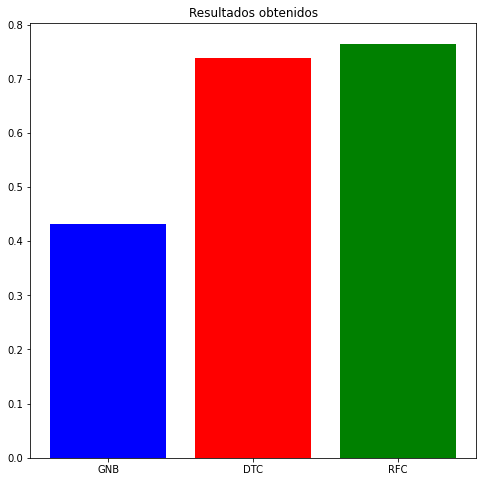

In [ ]:
plt.figure(figsize=(8,8))
plt.bar('GNB',accuracies[0], color = 'b')
plt.bar('DTC',accuracies[1], color = 'r')
plt.bar('RFC',accuracies[2], color = 'g')
plt.title('Resultados obtenidos')
print('Gaussian Naive Bayes: ' + str(accuracies[0]))
print('Decision Tree Classifier: ' + str(accuracies[1]))
print('Random Forest Classifier: ' + str(accuracies[2]))

# **Uso de DNN**
Debido a la poca cantidad de elementos se utilizaron diferentes métodos para evitar underfitting o overfitting.

El modelo consiste en 4 capas de 500, 256, 128 y 2 neuronas respectivamente, con 20 epochs y 20 de batch_size. Usando Relu como función de activación.

## **LeaveOneOut**

In [ ]:
loo = LeaveOneOut()
list_a = []
train_Ac = []
val_Ac = []
for train_index, test_index in loo.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=2)
  y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=2)
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= (X_train[0].shape)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)                           
  ])
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  history = model.fit(X_train, y_train_ohe, epochs=20, batch_size=20, validation_data=(X_test, y_test_ohe), shuffle=True)
  train_Ac.append(history.history['accuracy'])
  val_Ac.append(history.history['val_accuracy'])
  test_loss, test_acc = model.evaluate(X_test, y_test_ohe)
  list_a.append(test_acc)

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 24ms/step - loss: 0.5694 - accuracy: 0.7303 - val_loss: 1.4629 - val_accuracy: 0.0000e+00
Epoch 3/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5477 - accuracy: 0.7303 - val_loss: 1.2237 - val_accuracy: 0.0000e+00
Epoch 4/20
8/8 [==============================] - 0s 25ms/step - loss: 0.5371 - accuracy: 0.7303 - val_loss: 1.1666 - val_accuracy: 0.0000e+00
Epoch 5/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5312 - accuracy: 0.7303 - val_loss: 1.2592 - val_accuracy: 0.0000e+00
Epoch 6/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5238 - accuracy: 0.7303 - val_loss: 1.3386 - val_accuracy: 0.0000e+00
Epoch 7/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5195 - accuracy: 0.7303 - val_loss: 1.3802 - val_accuracy: 0.0000e+00
Epoch 8/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5090 - accuracy: 0.7303 - val

### **Resultados LeaveOneOut**

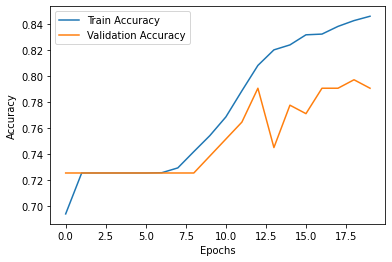

In [ ]:
t = np.array(train_Ac)
t = np.mean(t, axis = 0)
a = np.array(val_Ac)
a = np.mean(a, axis = 0)
plt.plot(t, label='Train Accuracy')
plt.plot(a, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
accuracies2 = []
accuracies2.append(np.mean(list_a))

## **Kfold**

In [ ]:
def creacionModelo(size):
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= (size.shape)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)                           
  ])
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [ ]:
n_split=11
list_a = []
train_Ac = []
val_Ac = []
for train_index,test_index in KFold(n_split, shuffle=True).split(X):
  x_train,x_test=X[train_index],X[test_index]
  y_train,y_test=y[train_index],y[test_index]
  y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=2)
  y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=2)
  model=creacionModelo(x_train[0])
  history = model.fit(x_train, y_train_ohe,epochs=20, batch_size=20, validation_data=(x_test, y_test_ohe))
  train_Ac.append(history.history['accuracy'])
  val_Ac.append(history.history['val_accuracy'])
  test_loss, test_acc = model.evaluate(x_test,y_test_ohe)
  list_a.append(test_acc)

Epoch 1/20
7/7 [==============================] - 1s 53ms/step - loss: 0.6713 - accuracy: 0.6259 - val_loss: 0.5780 - val_accuracy: 0.8571
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 0.5975 - accuracy: 0.7122 - val_loss: 0.4298 - val_accuracy: 0.8571
Epoch 3/20
7/7 [==============================] - 0s 21ms/step - loss: 0.5699 - accuracy: 0.7122 - val_loss: 0.4074 - val_accuracy: 0.8571
Epoch 4/20
7/7 [==============================] - 0s 21ms/step - loss: 0.5567 - accuracy: 0.7122 - val_loss: 0.4352 - val_accuracy: 0.8571
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.5485 - accuracy: 0.7122 - val_loss: 0.4486 - val_accuracy: 0.8571
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 0.5470 - accuracy: 0.7122 - val_loss: 0.4357 - val_accuracy: 0.8571
Epoch 7/20
7/7 [==============================] - 0s 19ms/step - loss: 0.5389 - accuracy: 0.7122 - val_loss: 0.4272 - val_accuracy: 0.8571
Epoch 8/20
7/7 [===========

### **Resultados Kfold**

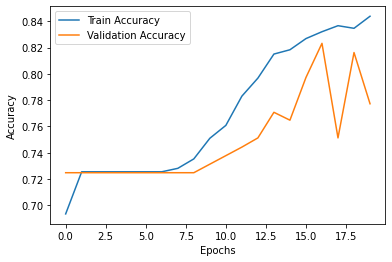

In [ ]:
t = np.array(train_Ac)
t = np.mean(t, axis = 0)
a = np.array(val_Ac)
a = np.mean(a, axis = 0)
plt.plot(t, label='Train Accuracy')
plt.plot(a, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
accuracies2.append(np.mean(list_a))

LeaveOneOut:0.7908496732026143
Kfols:0.7772227742455222


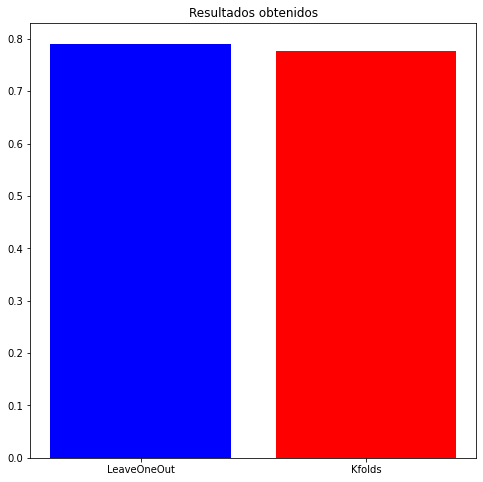

In [ ]:
plt.figure(figsize=(8,8))
plt.bar('LeaveOneOut',accuracies2[0], color = 'b')
plt.bar('Kfolds',accuracies2[1], color = 'r')
plt.title('Resultados obtenidos')
print('LeaveOneOut:' + str(accuracies2[0]))
print('Kfols:' + str(accuracies2[1]))

# **Uso de melspectogramas**

(128, 181)


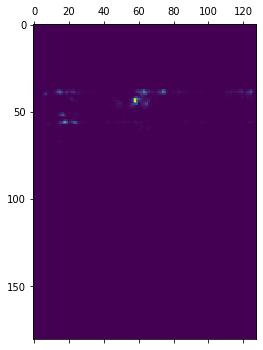

In [ ]:
wav, sr = librosa.load('/content/drive/My Drive/Cositas UIS/IA 1/Coughs/'+file_name)
SP = librosa.feature.melspectrogram(wav)
print( SP.shape)
plt.matshow(SP.T)

## **Configuración de melspectogramas**

In [ ]:
def get_Xy_Features(DATA_DIR = '/content/drive/My Drive/Cositas UIS/IA 1/Coughs/', pad_size=4000):
    
  X = []
  y = []

  for fname in os.listdir(DATA_DIR):
    struct = fname.split('-')
    if struct[0] == 'C':
      struct[0] = '1'
    else:
      struct[0] = '0'
    digit = struct[0]
    wav, sr = librosa.load(DATA_DIR + fname)
    D = librosa.feature.melspectrogram(wav)
    padded = func_padding(D.reshape(D.shape[0]*D.shape[1]), pad_size)
    X.append(padded)
    y.append(digit)
  return np.vstack(X), np.array(y)

## **DNN SENCILLA**

In [ ]:
X1, y1 = get_Xy_Features()

print( 'X:', X1.shape)
print( 'y:', y1.shape)

test_size = 0.15
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=test_size)

y_train_ohe1 = tf.keras.utils.to_categorical(y_train1, num_classes=2)
y_test_ohe1 = tf.keras.utils.to_categorical(y_test1, num_classes=2)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= (X_train1[0].shape)),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(32, activation='relu'),       
    tf.keras.layers.Dense(8, activation='relu'),                     
    tf.keras.layers.Dense(2, activation='sigmoid')                
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train1, y_train_ohe1, epochs=30, batch_size=100, shuffle=True, validation_data=(X_test1, y_test_ohe1))
test_loss, test_acc = model.evaluate(X_test1, y_test_ohe1, verbose=False)
print( 'Test accuracy:', test_acc, " test_loss: ", test_loss)

X: (153, 4000)
y: (153,)
Model: "sequential_541"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_541 (Flatten)       (None, 4000)              0         
                                                                 
 dense_2362 (Dense)          (None, 128)               512128    
                                                                 
 dense_2363 (Dense)          (None, 64)                8256      
                                                                 
 dense_2364 (Dense)          (None, 32)                2080      
                                                                 
 dense_2365 (Dense)          (None, 8)                 264       
                                                                 
 dense_2366 (Dense)          (None, 2)                 18        
                                                                 
Total params: 522,746
Train

### **Resultados DNN Sencilla**

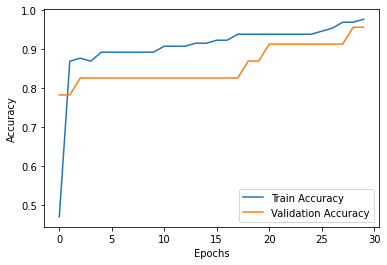

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
accuracies3 = []
accuracies3.append(test_acc)

## **DNN con LeaveOneOut**

In [ ]:
X2, y2 = get_Xy_Features()

loo = LeaveOneOut()
list_a = []
train_Ac = []
val_Ac = []
for train_index, test_index in loo.split(X2):
  X_train, X_test = X2[train_index], X2[test_index]
  y_train, y_test = y2[train_index], y2[test_index]
  y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=2)
  y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=2)
  model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= X_train[0].shape),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(32, activation='relu'),       
    tf.keras.layers.Dense(8, activation='relu'),                     
    tf.keras.layers.Dense(2, activation='sigmoid')                             
  ])
  model2.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  history = model2.fit(X_train, y_train_ohe, epochs=25, batch_size=80, shuffle=True, validation_data=(X_test, y_test_ohe))
  train_Ac.append(history.history['accuracy'])
  val_Ac.append(history.history['val_accuracy'])
  test_loss, test_acc = model2.evaluate(X_test, y_test_ohe)
  list_a.append(test_acc)
print( np.mean(list_a))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step - loss: 0.1490 - accuracy: 1.0000
Epoch 1/25
2/2 [==============================] - 1s 211ms/step - loss: 0.6979 - accuracy: 0.5329 - val_loss: 0.6868 - val_accuracy: 1.0000
Epoch 2/25
2/2 [==============================] - 0s 47ms/step - loss: 0.6747 - accuracy: 0.8487 - val_loss: 0.6794 - val_accuracy: 1.0000
Epoch 3/25
2/2 [==============================] - 0s 49ms/step - loss: 0.6636 - accuracy: 0.8553 - val_loss: 0.6709 - val_accuracy: 1.0000
Epoch 4/25
2/2 [==============================] - 0s 61ms/step - loss: 0.6526 - accuracy: 0.8618 - val_loss: 0.6614 - val_accuracy: 1.0000
Epoch 5/25
2/2 [==============================] - 0s 60ms/step - loss: 0.6402 - accuracy: 0.8750 - val_loss: 0.6510 - val_accuracy: 1.0000
Epoch 6/25
2/2 [==============================] - 0s 45ms/step - loss: 0.6282 - accuracy: 0.8750 - val_loss: 0.6398 - val_accuracy: 1.0000
Epoch 7/25
2/2 [============

### **Resultados DNN con LeaveOneOut**

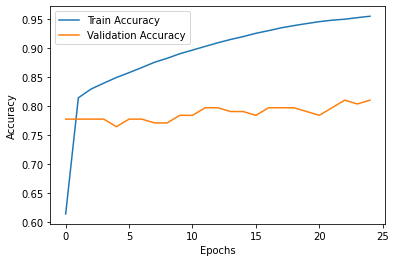

In [ ]:
t = np.array(train_Ac)
t = np.mean(t, axis = 0)
a = np.array(val_Ac)
a = np.mean(a, axis = 0)
plt.plot(t, label='Train Accuracy')
plt.plot(a, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
accuracies3.append(np.mean(list_a))

## **Resultados**

Sencilla:0.95652174949646
LeaveOneOut:0.8104575163398693


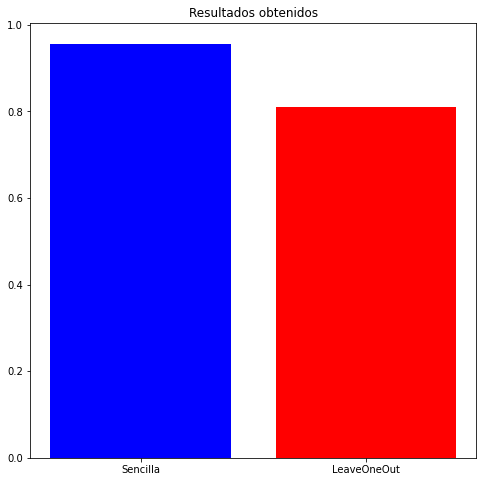

In [ ]:
plt.figure(figsize=(8,8))
plt.bar('Sencilla',accuracies3[0], color = 'b')
plt.bar('LeaveOneOut',accuracies3[1], color = 'r')
plt.title('Resultados obtenidos')
print('Sencilla:' + str(accuracies3[0]))
print('LeaveOneOut:' + str(accuracies3[1]))

# **RESULTADOS**

Text(0.5, 1.0, 'Resultados obtenidos')

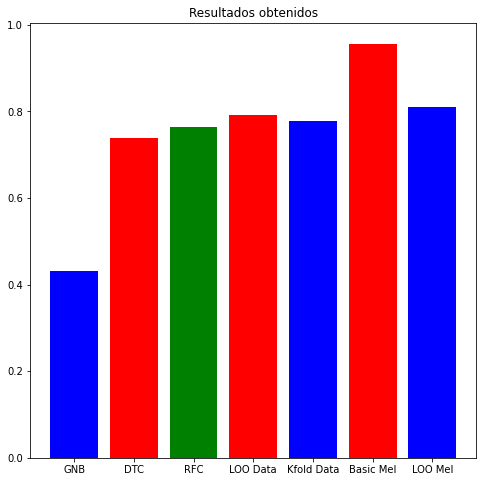

In [62]:
plt.figure(figsize=(8,8))
plt.bar('GNB',accuracies[0], color = 'b')
plt.bar('DTC',accuracies[1], color = 'r')
plt.bar('RFC',accuracies[2], color = 'g')
plt.bar('LOO Data',accuracies2[0], color = 'r')
plt.bar('Kfold Data',accuracies2[1], color = 'b')
plt.bar('Basic Mel',accuracies3[0], color = 'r')
plt.bar('LOO Mel',accuracies3[1], color = 'b')
plt.title('Resultados obtenidos')